In [1]:
import h5py
import matplotlib
import pickle

import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc

from matplotlib import animation

from IPython.display import Video

import skies

%config InlineBackend.figure_format = "retina"

# Read in time series, mesh geometry, and mesh evolution

In [21]:
time_series_file_name = "time_series.pickle"
mesh_parameters_file_name = "nankai_mesh_parameters.json"
hdf_filename = "2024_03_22_18_23_31.hdf"

# Read time series
with open(time_series_file_name, "rb") as f:
    time_series = pickle.load(f)

# Read mesh information
mesh = skies.read_meshes(mesh_parameters_file_name)

# Read hdf mesh evolution information
with h5py.File(hdf_filename, "r") as f:
    print("Keys: %s" % f.keys())

    for key in f.keys():
        print(f"{key=}")

    print(list(f.keys())[0])
    # print(f.keys()[0])

    # Get cumulative slip
    group_key = list(f.keys())[0]
    cumulative_slip = f[group_key][()]

    # Get geometric moment
    group_key = list(f.keys())[1]
    geometric_moment = f[group_key][()]

Warning: The file contains tag data that couldn't be processed.

Keys: <KeysViewHDF5 ['cumulative_slip', 'geometric_moment', 'loading_rate']>
key='cumulative_slip'
key='geometric_moment'
key='loading_rate'
cumulative_slip


In [3]:
def plot_meshes(mesh, fill_value, ax, cmap_string):
    x_coords = mesh.meshio_object.points[:, 0]
    y_coords = mesh.meshio_object.points[:, 1]
    vertex_array = np.asarray(mesh.verts)

    if not ax:
        ax = plt.gca()
    xy = np.c_[x_coords, y_coords]
    verts = xy[vertex_array]
    pc = matplotlib.collections.PolyCollection(
        verts,
        edgecolor="None",
        cmap=cmap_string,
        linewidth=0.0,
        alpha=1.0,
    )
    pc.set_array(fill_value)
    ax.add_collection(pc)
    ax.autoscale()
    plt.gca().set_aspect("equal")
    return pc

Keys: <KeysViewHDF5 ['cumulative_slip', 'geometric_moment', 'loading_rate']>


# Animate cumulative coseismic slip

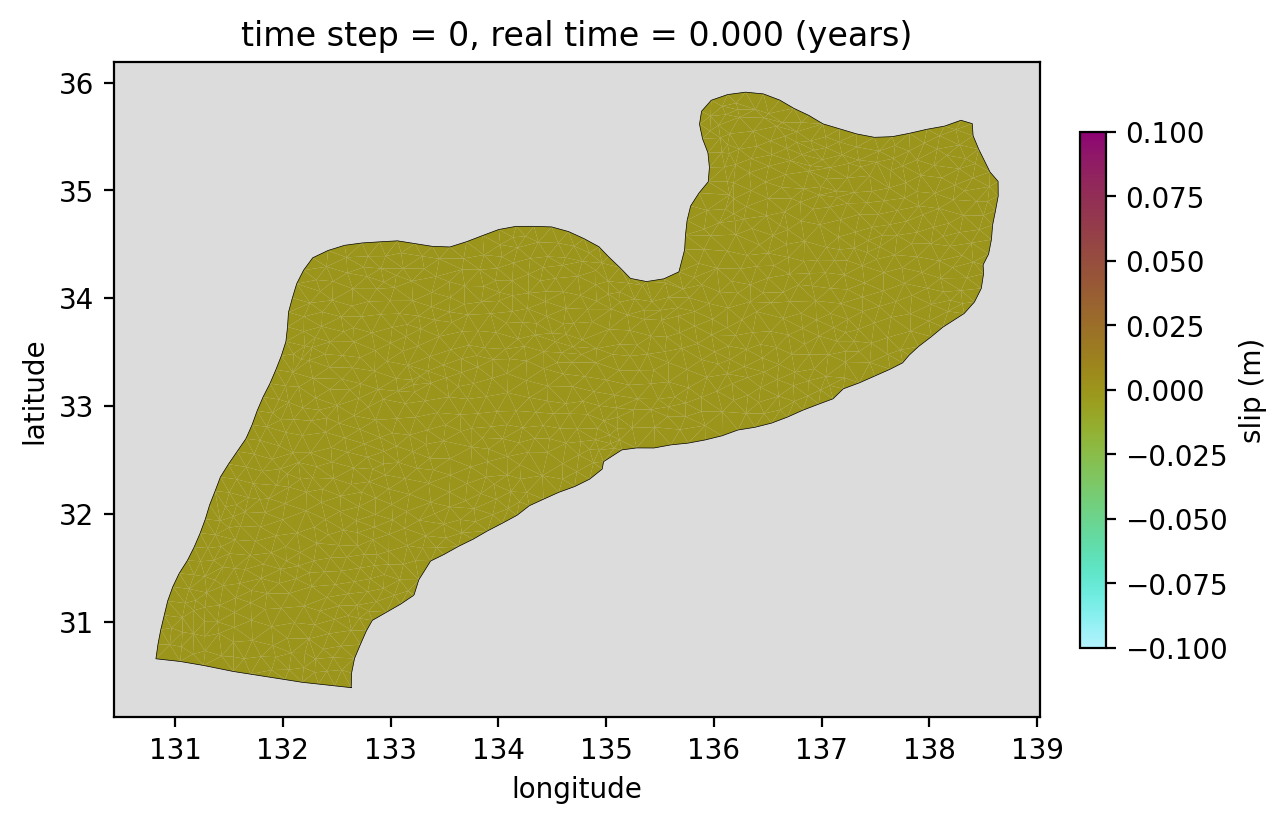

In [14]:
fig, ax = plt.subplots()
to_plot = cumulative_slip[0, :]
pc = plot_meshes(mesh[0], to_plot, plt.gca(), cmc.hawaii_r)
plt.colorbar(pc, fraction=0.026, pad=0.04, label="slip (m)")
pc.set_clim(0, 1e1)
plt.plot(mesh[0].x_perimeter, mesh[0].y_perimeter, "-k", linewidth=0.25)
plt.gca().set_facecolor("gainsboro")
plt.xlabel("longitude")
plt.ylabel("latitude")


def animate(i):
    pc.set_array(cumulative_slip[i, :])
    pc.set_clim(0, np.max(cumulative_slip[i, :]))
    plt.title(f"time step = {i}, real time = {time_series.real_time[i]:0.3f} (years)")


anim = animation.FuncAnimation(fig, animate, interval=1, frames=10000)
anim.save(filename="cumulative_slip.mp4", writer="ffmpeg", dpi=100)
Video("cumulative_slip.mp4", width=500, height=500)

# Animate geometric moment evolution

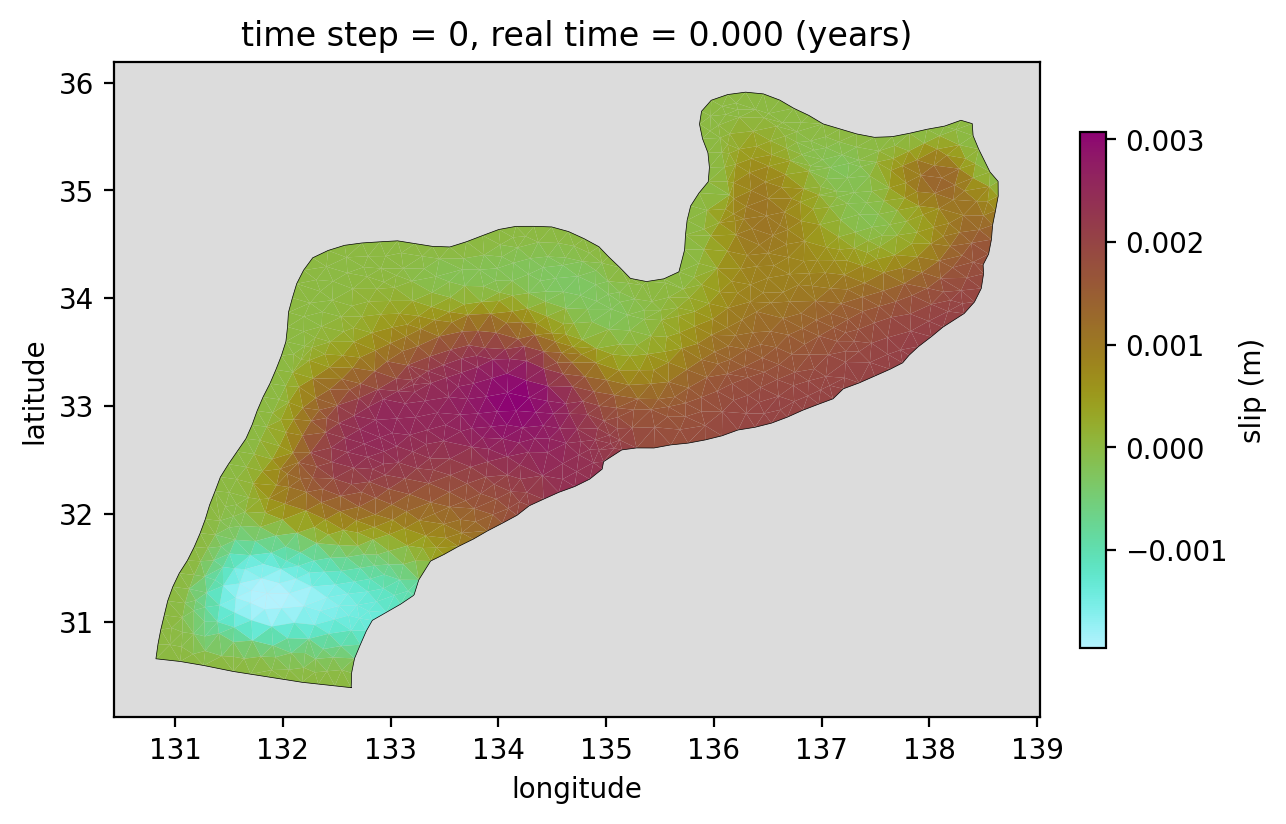

In [7]:
fig, ax = plt.subplots()
to_plot = geometric_moment[0, :] / mesh[0].areas
pc = plot_meshes(mesh[0], to_plot, plt.gca(), cmc.hawaii_r)
plt.colorbar(pc, fraction=0.026, pad=0.04, label="slip (m)")
# pc.set_clim(0, 1e1)
plt.plot(mesh[0].x_perimeter, mesh[0].y_perimeter, "-k", linewidth=0.25)
plt.gca().set_facecolor("gainsboro")
plt.xlabel("longitude")
plt.ylabel("latitude")


def animate(i):
    to_plot = geometric_moment[i, :] / mesh[0].areas
    pc.set_array(to_plot)
    pc.set_clim(np.min(to_plot), np.max(to_plot))
    plt.title(f"time step = {i}, real time = {time_series.real_time[i]:0.3f} (years)")


anim = animation.FuncAnimation(fig, animate, interval=1, frames=10000)
anim.save(filename="geometric_moment.mp4", writer="ffmpeg", dpi=100)
Video("geometric_moment.mp4", width=500, height=500)